In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import numpy as np
from tqdm.auto import tqdm


from utils.plots import visualize_vehicle_trajectories, plot_interactive_matrix, visualize_merge_pairs_grid, visualize_merge_chains_grid
from utils.loader import load_data_from_database
from utils.transformer import categorize_ids, find_merging_pairs, build_merge_chains

/Users/workflow/FHNW git/HS2025 git/Traffic-monitoring-Challenge/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Do you want to load data from the database? This may take a while.")
if input("Type 'y' to proceed: ").lower() == 'y':
    df = load_data_from_database()
    df = df.sort_values(['date_time', 'frame_id'])
else:
    df = pd.read_csv("raw_traffic_data.csv", parse_dates=['date_time'])
    df = df.sort_values(['date_time', 'frame_id'])

Do you want to load data from the database? This may take a while.


In [3]:
df['session_id'] = (
    (df['frame_id'].diff() < 0)
).cumsum()

In [4]:
df.groupby('session_id').agg('size')

session_id
0       28090
1       15936
2     8238814
3       33537
4        7082
5       10582
6        8504
7       17186
8       30834
9        5361
10      26281
11      17976
12      12914
13      26303
14     489001
15      17536
dtype: int64

In [77]:
# 1. Select one stable session and sort
session_id_to_analyze = 2
session_df = df[df['session_id'] == session_id_to_analyze].sort_values(['vehicle_id', 'date_time'])

# Filter vehicle_id with less than 40 records
vehicle_counts = session_df['vehicle_id'].value_counts()
valid_vehicles = vehicle_counts[vehicle_counts >= 30].index
session_df = session_df[session_df['vehicle_id'].isin(valid_vehicles)]


In [78]:
final_summary = categorize_ids(session_df)
final_summary.groupby('category').agg('size')

category
Flickering          258
Partial           18294
Perfect           28434
RelayCandidate    12882
Static            23273
dtype: int64

In [79]:
fig = plot_interactive_matrix(final_summary, max_points_per_category=500)
fig.show()


In [80]:
filter_category = 'Perfect'
filtered_final_summary = final_summary[(final_summary['category'] == filter_category)]
filtered_final_summary

,session_id,vehicle_id,y_start,y_end,w_mean,w_std,h_mean,h_std,frames_count,t_start,t_end,x_mean,x_std,path_completeness,w_cv,h_cv,movement_efficiency,category
0,2,3,266,0,40.458333,4.712854,62.750000,18.379568,48,2025-11-29 18:04:13.894244,2025-11-29 18:04:17.009382,134.895833,2.998153,0.917241,0.116487,0.292901,0.019109,Perfect
1,2,4,263,0,39.704348,4.643377,56.808696,17.317416,115,2025-11-29 18:04:24.233579,2025-11-29 18:04:31.759723,139.086957,2.019924,0.906897,0.116949,0.304837,0.007886,Perfect
2,2,15,0,268,77.970588,19.237724,109.852941,45.862860,34,2025-11-29 18:04:49.929169,2025-11-29 18:04:52.215478,35.205882,22.581542,0.924138,0.246731,0.417493,0.027181,Perfect
4,2,19,0,266,41.387755,3.516724,75.653061,23.496056,49,2025-11-29 18:05:00.020414,2025-11-29 18:05:03.110749,37.408163,10.454103,0.917241,0.084970,0.310576,0.018719,Perfect
7,2,27,271,0,60.679012,10.346575,92.067901,73.442767,162,2025-11-29 18:05:45.831297,2025-11-29 18:05:56.357031,136.135802,3.893786,0.934483,0.170513,0.797702,0.005768,Perfect
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83133,2,404131,0,262,62.142857,15.932193,88.559524,26.183942,84,2025-12-18 11:01:11.218138,2025-12-18 11:01:14.360564,22.488095,17.468384,0.903448,0.256380,0.295665,0.010755,Perfect
83134,2,404132,254,0,58.660000,9.560250,85.870000,35.789693,100,2025-12-18 11:01:49.007362,2025-12-18 11:01:52.920998,133.790000,3.814632,0.875862,0.162977,0.416789,0.008759,Perfect
83135,2,404133,264,0,47.870588,8.214082,59.200000,12.261826,85,2025-12-18 11:01:51.786257,2025-12-18 11:01:55.054317,142.188235,6.970165,0.910345,0.171589,0.207125,0.010710,Perfect
83136,2,404135,272,0,58.540323,10.001950,82.967742,29.568148,124,2025-12-18 11:01:57.507097,2025-12-18 11:02:02.401481,136.766129,4.540887,0.937931,0.170856,0.356381,0.007564,Perfect


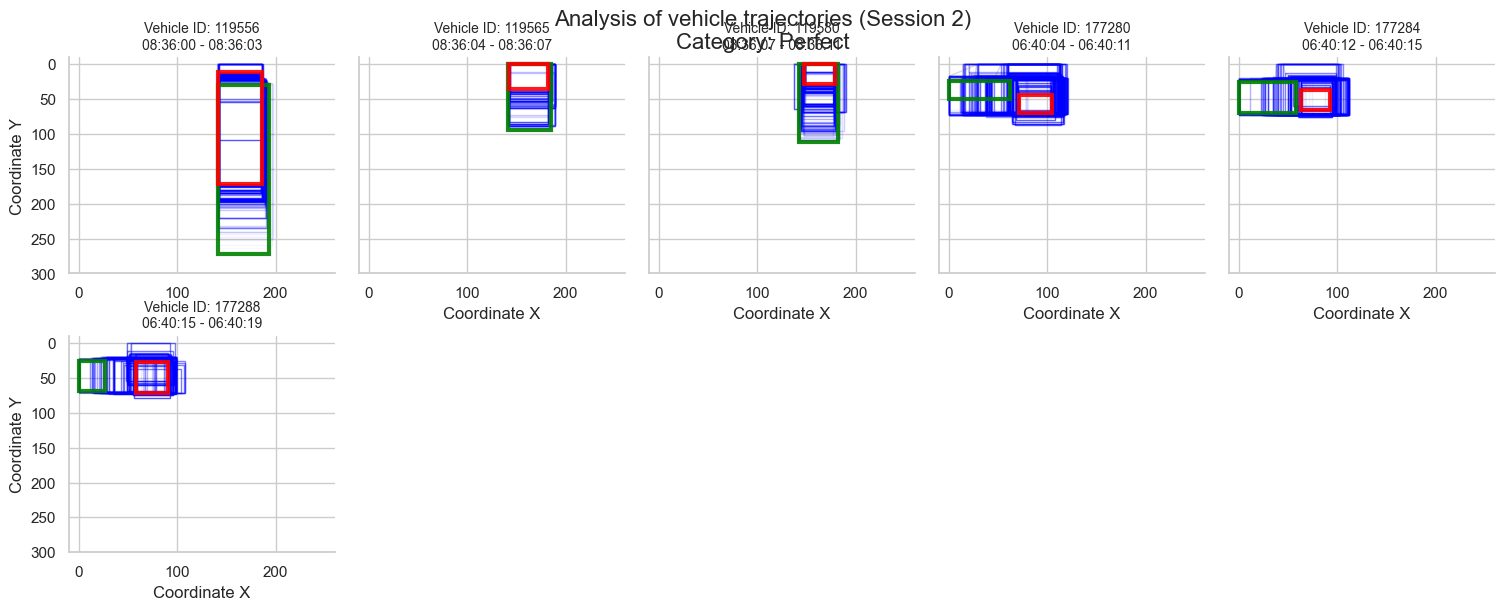

In [81]:
ids_to_plot = filtered_final_summary['vehicle_id']
ids_to_plot = [177280, 177284, 177288, 119556, 119565, 119580]
plot_data = session_df[session_df['vehicle_id'].isin(ids_to_plot)]
visualize_vehicle_trajectories(plot_data, session_id=session_id_to_analyze, max_vehicles=25, min_records=20, category=filter_category)

In [82]:
plot_data.groupby('vehicle_id').agg('size')

vehicle_id
119556     87
119565     57
119580    112
177280    169
177284     90
177288     87
dtype: int64

In [83]:

merge_results = find_merging_pairs(final_summary, category_filter=['RelayCandidate', 'Partial'])
print(f"Found pairs for merging: {len(merge_results)}")
merge_results

Search for pairs for merging: 100%|██████████| 31176/31176 [00:00<00:00, 579155.02ID/s]

Found pairs for merging: 821


,old_id,new_id,gap_sec,y_dist,size_diff_pct,old_x_start,old_y_start,old_x_end,old_y_end,new_x_start,new_y_start,new_x_end,new_y_end,old_t_start,old_t_end,new_t_start,new_t_end
0,2395,2400,0.39,23,2.3,48.6,0,48.6,38,57.0,61,57.0,255,2025-11-29 19:34:32.756998,2025-11-29 19:34:35.801374,2025-11-29 19:34:36.194726,2025-11-29 19:34:38.193299
1,2822,2824,0.15,12,3.5,49.0,0,49.0,50,59.4,62,59.4,260,2025-11-29 19:43:14.955705,2025-11-29 19:43:18.206759,2025-11-29 19:43:18.361589,2025-11-29 19:43:20.978062
2,6676,6680,1.26,34,10.9,120.1,42,120.1,15,129.7,49,129.7,0,2025-11-30 01:46:20.468426,2025-11-30 01:46:22.196439,2025-11-30 01:46:23.457651,2025-11-30 01:46:24.848855
3,21867,21873,0.74,22,8.8,26.9,0,26.9,92,38.7,70,38.7,165,2025-12-01 07:33:18.163074,2025-12-01 07:33:21.862830,2025-12-01 07:33:22.606114,2025-12-01 07:33:23.751648
4,22155,22160,0.27,18,0.1,23.8,0,23.8,33,23.3,51,23.3,264,2025-12-01 07:39:38.453759,2025-12-01 07:39:39.809394,2025-12-01 07:39:40.076063,2025-12-01 07:39:41.840095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816,402991,402993,0.30,5,1.8,0.0,0,0.0,48,0.0,53,0.0,113,2025-12-18 09:25:19.343946,2025-12-18 09:25:21.512641,2025-12-18 09:25:21.814327,2025-12-18 09:25:25.263767
817,403160,403163,0.07,22,15.0,130.5,266,130.5,66,134.4,44,134.4,0,2025-12-18 09:35:14.508610,2025-12-18 09:35:16.483024,2025-12-18 09:35:16.558023,2025-12-18 09:35:18.586401
818,403461,403470,1.15,6,5.8,135.7,277,135.7,152,138.0,146,138.0,90,2025-12-18 10:06:47.850284,2025-12-18 10:06:53.009489,2025-12-18 10:06:54.156286,2025-12-18 10:06:57.430744
819,403468,403472,0.82,15,17.9,140.2,227,140.2,179,138.7,164,138.7,76,2025-12-18 10:06:54.014610,2025-12-18 10:06:56.610029,2025-12-18 10:06:57.430744,2025-12-18 10:06:59.743444


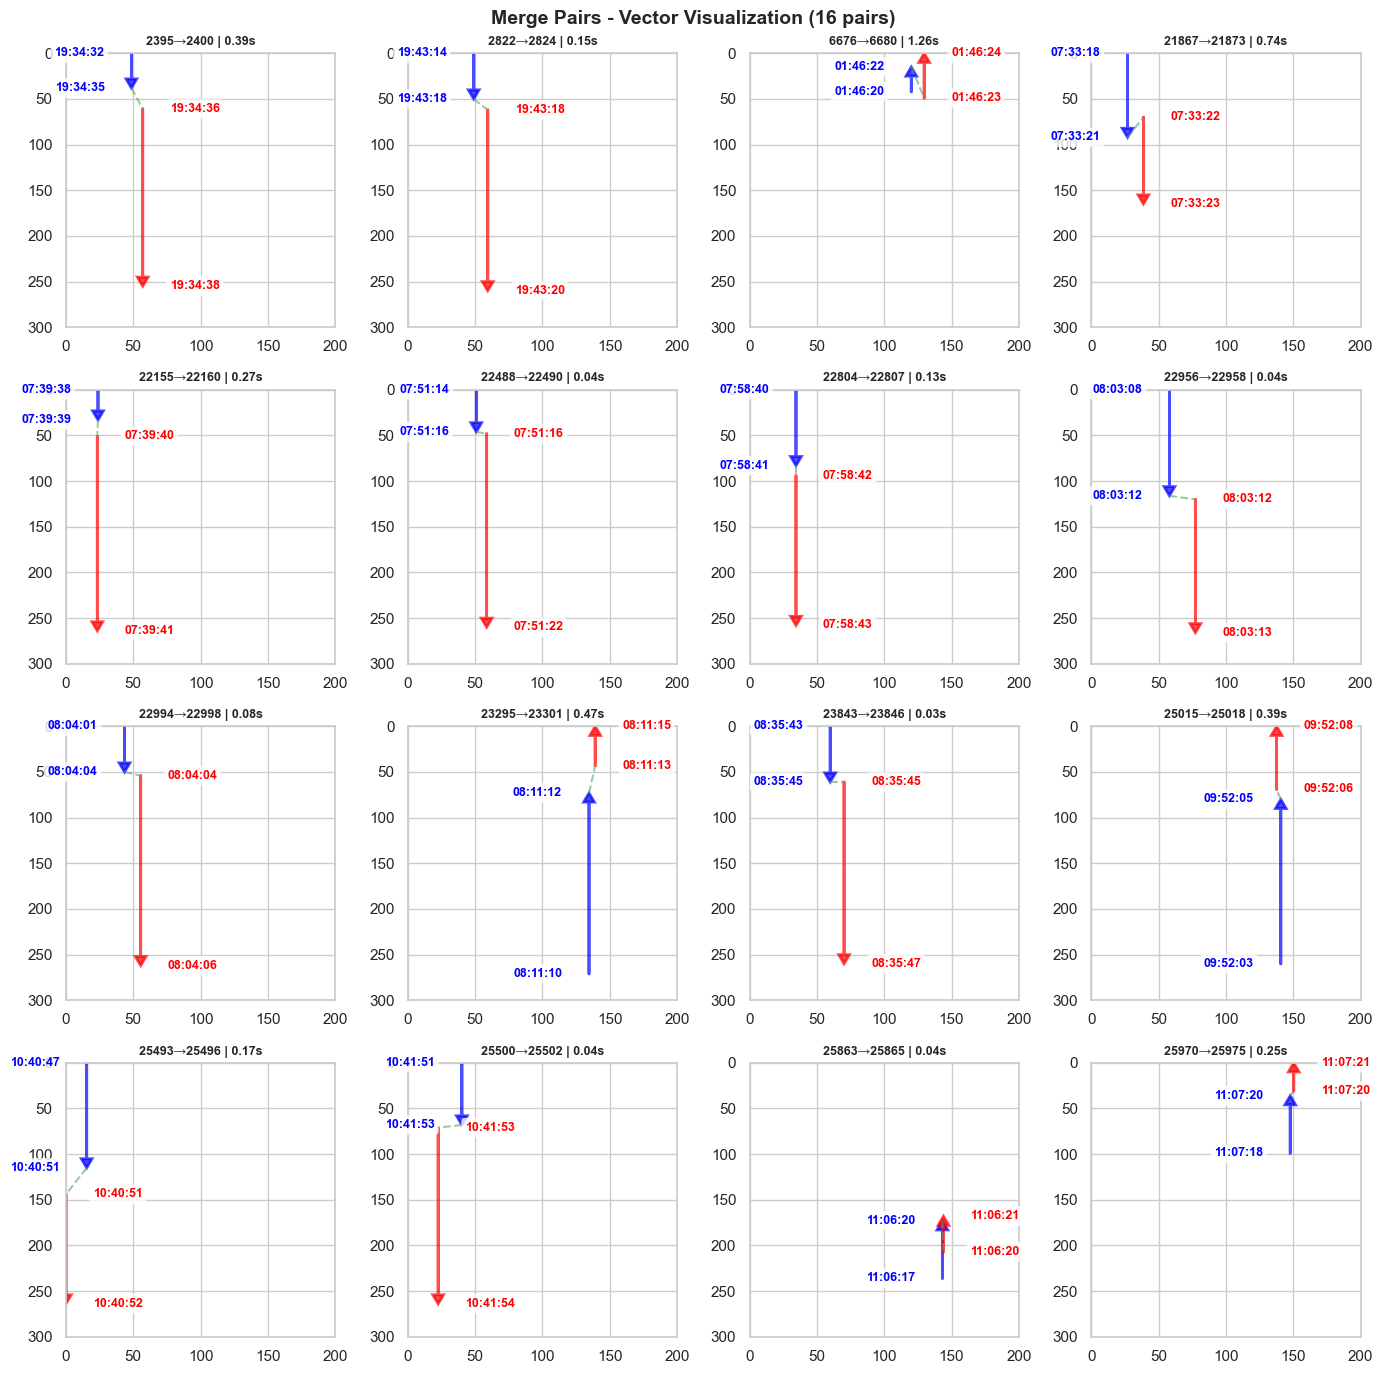

In [84]:
# Visualize
fig = visualize_merge_pairs_grid(merge_results, n_pairs=16, cols=4)
plt.show()


In [85]:
chains = build_merge_chains(merge_results)
print(f"Found {len(chains)} chains")
print(f"Longest chain has {max(len(c) for c in chains) if chains else 0} IDs")
print("\nFirst 10 chains (sorted by time):")
for i, chain in enumerate(chains[:10]):
    # Get start time for display
    first_id = chain[0]
    first_row = merge_results[merge_results['old_id'] == first_id].iloc[0] if len(merge_results[merge_results['old_id'] == first_id]) > 0 else None
    time_str = first_row['old_t_start'].strftime('%H:%M:%S') if first_row is not None else "??:??:??"
    print(f"{i+1}. [{time_str}] {' → '.join(map(str, chain))}")


Found 805 chains
Longest chain has 3 IDs

First 10 chains (sorted by time):
1. [19:34:32] 2395 → 2400
2. [19:43:14] 2822 → 2824
3. [01:46:20] 6676 → 6680
4. [07:33:18] 21867 → 21873
5. [07:39:38] 22155 → 22160
6. [07:51:14] 22488 → 22490
7. [07:58:40] 22804 → 22807
8. [08:03:08] 22956 → 22958
9. [08:04:01] 22994 → 22998
10. [08:11:10] 23295 → 23301


In [86]:
long_chains = [chain for chain in chains if len(chain) > 2]
print(f"Chains with more than 2 IDs: {len(long_chains)}")
long_chains 

Chains with more than 2 IDs: 16


[[32222, 32227, 32230],
 [35150, 35156, 35162],
 [103703, 103705, 103708],
 [125056, 125063, 125072],
 [125073, 125075, 125076],
 [180516, 180519, 180521],
 [189949, 189957, 189959],
 [190132, 190137, 190144],
 [237608, 237614, 237617],
 [279297, 279299, 279302],
 [281493, 281494, 281495],
 [290663, 290669, 290678],
 [335729, 335752, 335761],
 [346237, 346240, 346246],
 [363103, 363105, 363108],
 [384203, 384208, 384211]]

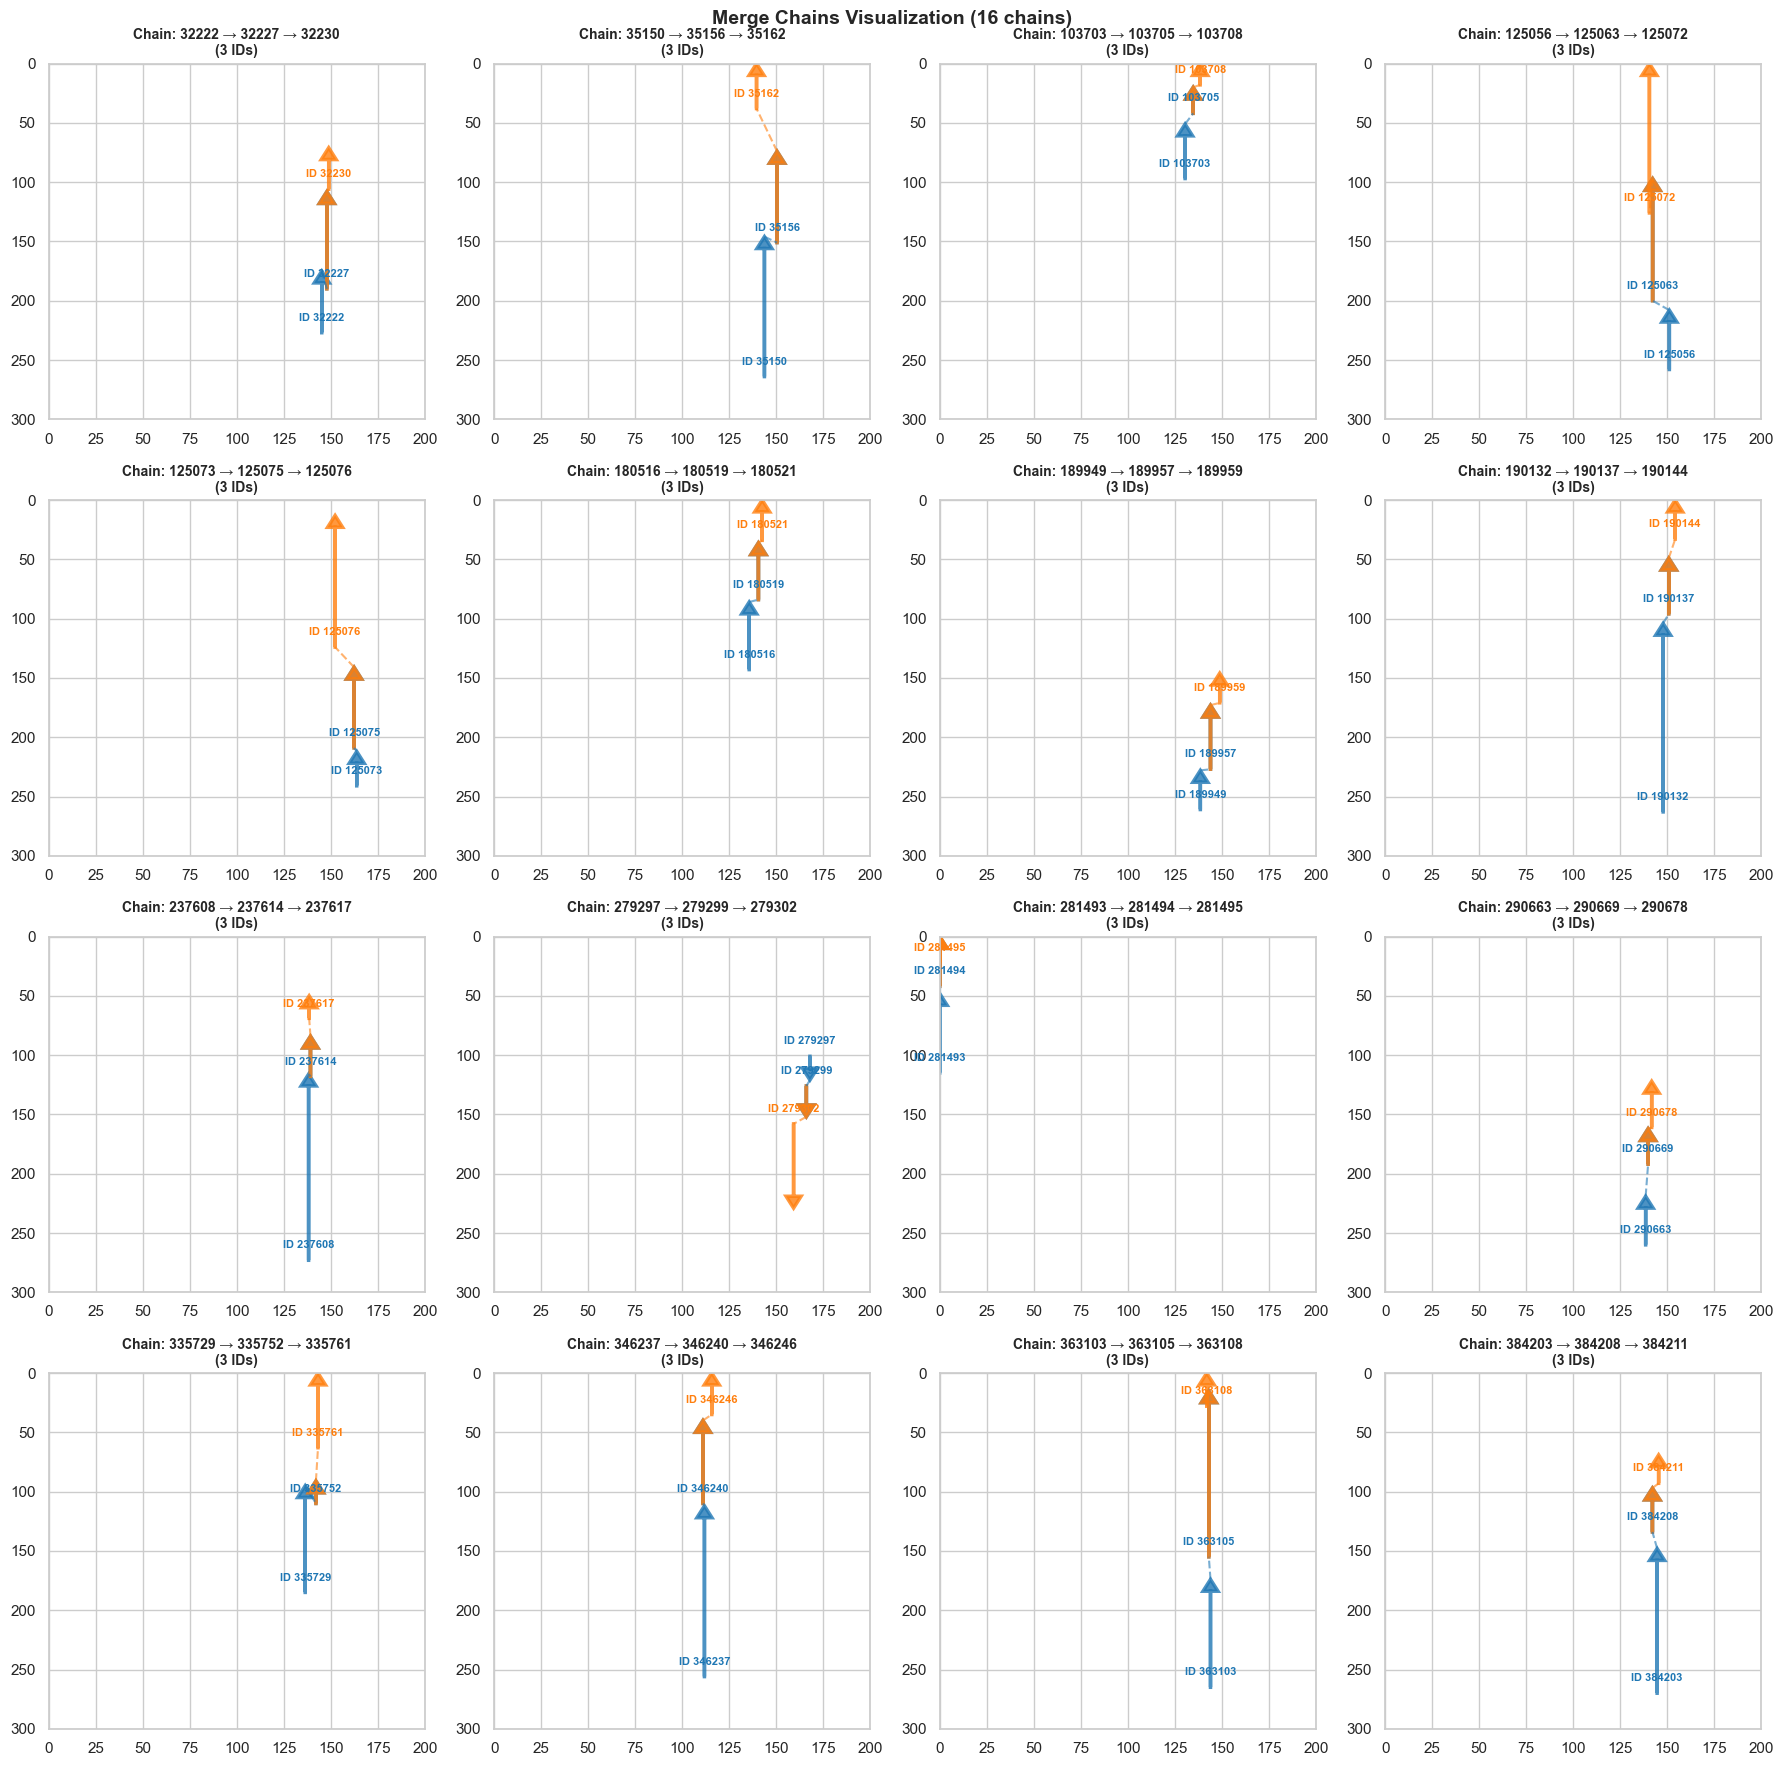

In [87]:
# Visualize chains
fig = visualize_merge_chains_grid(merge_results, long_chains, n_chains=16, cols=4)
plt.show()


In [88]:
# df['year'] = df['date_time'].dt.year
# df['month'] = df['date_time'].dt.month
# df['day'] = df['date_time'].dt.day
# df['hour'] = df['date_time'].dt.hour
# df['unique_vehicle_id'] = round(df['vehicle_id'] + df['year']/10000 + df['month']/1000000 + df['day']/100000000 + df['hour']/10000000000, 10)
# df['unique_frame_id'] = round(df['vehicle_id'] + df['year']/10000 + df['month']/1000000 + df['day']/100000000 + df['hour']/10000000000, 10)
# df.head()

In [89]:
# df['size'] = df['width'] * df['heigth']
# df.head()

In [90]:
# min_max_df = df.groupby('unique_vehicle_id')[['size', 'y']].agg(['max', 'min']).sort_index()

In [91]:
# min_max_df['way_size'] = min_max_df['y']['max'] - min_max_df['y']['min']
# min_max_df.columns = ['size_max', 'size_min', 'y_max', 'y_min', 'way_size']
# min_max_df.head()

In [92]:
# min_max_df['full_way'] = min_max_df['way_size'] > 240

In [93]:
# min_max_df['day'] = min_max_df.index.map(lambda x: True if 6 <= int((x* 10000000000)%100) < 18 else False)

In [94]:
# min_max_df